In [83]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [85]:
# URL of the CSV file (example)
url = "https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2023-24/gws/merged_gw.csv"

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(url)

In [255]:
def fetch_data(url):
    df = pd.read_csv(url, encoding="latin1")

    if 'expected_assists' in df.columns:
        df.drop('expected_assists', axis=1, inplace=True)
        df.drop('expected_goal_involvements', axis=1, inplace=True)
        df.drop('expected_goals', axis=1, inplace=True)
        df.drop('expected_goals_conceded', axis=1, inplace=True)
        df.drop('starts', axis=1, inplace=True)

    gks=df.loc[(df['position']=="GK")]
    defs=df.loc[(df['position']=="DEF") ]
    mids=df.loc[(df['position']=="MID")]
    fwds=df.loc[(df['position']=="FWD") ]

    print(df.columns)

    return gks, defs, mids, fwds

In [257]:
gks=[]
defs=[]
mids=[]
fwds=[]
gks_test=[]
defs_test=[]
mids_test=[]
fwds_test=[]

In [259]:
for i in range(20,23):
    url = "https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/20" + str(i) + "-" + str(i+1) + "/gws/merged_gw.csv"
    print(url)
    gks_temp, defs_temp, mids_temp, fwds_temp=fetch_data(url)
    if i < 22:
        gks.append(gks_temp)
        defs.append(defs_temp)
        mids.append(gks_temp)
        fwds.append(fwds_temp)
    else:
        gks_test.append(gks_temp)
        defs_test.append(defs_temp)
        mids_test.append(gks_temp)
        fwds_test.append(fwds_temp)

https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2020-21/gws/merged_gw.csv
Index(['name', 'position', 'team', 'xP', 'assists', 'bonus', 'bps',
       'clean_sheets', 'creativity', 'element', 'fixture', 'goals_conceded',
       'goals_scored', 'ict_index', 'influence', 'kickoff_time', 'minutes',
       'opponent_team', 'own_goals', 'penalties_missed', 'penalties_saved',
       'red_cards', 'round', 'saves', 'selected', 'team_a_score',
       'team_h_score', 'threat', 'total_points', 'transfers_balance',
       'transfers_in', 'transfers_out', 'value', 'was_home', 'yellow_cards',
       'GW'],
      dtype='object')
https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2021-22/gws/merged_gw.csv
Index(['name', 'position', 'team', 'xP', 'assists', 'bonus', 'bps',
       'clean_sheets', 'creativity', 'element', 'fixture', 'goals_conceded',
       'goals_scored', 'ict_index', 'influence', 'kickoff_time', 'minutes',
       'opponent_team', 'ow

In [260]:
gks_test=gks_test[0]
defs_test=defs_test[0]
mids_test=mids_test[0]
fwds_test=fwds_test[0]

In [261]:
gks_test.columns

Index(['name', 'position', 'team', 'xP', 'assists', 'bonus', 'bps',
       'clean_sheets', 'creativity', 'element', 'fixture', 'goals_conceded',
       'goals_scored', 'ict_index', 'influence', 'kickoff_time', 'minutes',
       'opponent_team', 'own_goals', 'penalties_missed', 'penalties_saved',
       'red_cards', 'round', 'saves', 'selected', 'team_a_score',
       'team_h_score', 'threat', 'total_points', 'transfers_balance',
       'transfers_in', 'transfers_out', 'value', 'was_home', 'yellow_cards',
       'GW'],
      dtype='object')

In [262]:
gks_df=pd.concat(gks, ignore_index=True)
defs_df=pd.concat(defs, ignore_index=True)
mids_df=pd.concat(mids, ignore_index=True)
fwds_df=pd.concat(fwds, ignore_index=True)

In [263]:
from sklearn.model_selection import train_test_split

In [269]:
y_gks=gks_df['total_points']
y_defs=defs_df['total_points']
y_mids=mids_df['total_points']
y_fwds=fwds_df['total_points']

x_gks=gks_df.drop(['total_points', 'name', 'position', 'team', 'kickoff_time'], axis =1)
x_defs=defs_df.drop(['total_points', 'name', 'position', 'team', 'kickoff_time'], axis =1)
x_mids=mids_df.drop(['total_points', 'name', 'position', 'team', 'kickoff_time'], axis =1)
x_fwds=fwds_df.drop(['total_points', 'name', 'position', 'team', 'kickoff_time'], axis =1)

In [271]:
y_gks_test=gks_test['total_points']
y_defs_test=defs_test['total_points']
y_mids_test=mids_test['total_points']
y_fwds_test=fwds_test['total_points']

x_gks_test=gks_test.drop(['total_points', 'name', 'position', 'team', 'kickoff_time'], axis =1)
x_defs_test=defs_test.drop(['total_points', 'name', 'position', 'team', 'kickoff_time'], axis =1)
x_mids_test=mids_test.drop(['total_points', 'name', 'position', 'team', 'kickoff_time'], axis =1)
x_fwds_test=fwds_test.drop(['total_points', 'name', 'position', 'team', 'kickoff_time'], axis =1)

In [241]:
y_gks

0       1
1       0
2       2
3       1
4       0
       ..
5572    0
5573    2
5574    0
5575    1
5576    0
Name: total_points, Length: 5577, dtype: int64

In [243]:
x_gks.head(5)

,xP,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,...,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
0,2.5,0,0,12,0,0.0,483,8,2,0,...,2,0,0.0,0,0,0,50,True,0,1
1,3.3,0,0,0,0,0.0,245,3,0,0,...,3,4,0.0,0,0,0,45,True,0,1
2,1.8,0,0,17,0,0.0,363,1,1,0,...,0,1,0.0,0,0,0,45,False,0,1
3,5.5,0,0,9,0,0.0,252,3,3,0,...,3,4,0.0,0,0,0,60,True,0,1
4,0.8,0,0,0,0,0.0,516,2,0,0,...,3,0,0.0,0,0,0,45,True,0,1


In [273]:
from sklearn.linear_model import LinearRegression

In [275]:
reg = LinearRegression().fit(x_gks, y_gks)

In [277]:
reg.feature_names_in_

array(['xP', 'assists', 'bonus', 'bps', 'clean_sheets', 'creativity',
       'element', 'fixture', 'goals_conceded', 'goals_scored',
       'ict_index', 'influence', 'minutes', 'opponent_team', 'own_goals',
       'penalties_missed', 'penalties_saved', 'red_cards', 'round',
       'saves', 'selected', 'team_a_score', 'team_h_score', 'threat',
       'transfers_balance', 'transfers_in', 'transfers_out', 'value',
       'was_home', 'yellow_cards', 'GW'], dtype=object)

In [279]:
print(x_gks_test.columns)

Index(['xP', 'assists', 'bonus', 'bps', 'clean_sheets', 'creativity',
       'element', 'fixture', 'goals_conceded', 'goals_scored', 'ict_index',
       'influence', 'minutes', 'opponent_team', 'own_goals',
       'penalties_missed', 'penalties_saved', 'red_cards', 'round', 'saves',
       'selected', 'team_a_score', 'team_h_score', 'threat',
       'transfers_balance', 'transfers_in', 'transfers_out', 'value',
       'was_home', 'yellow_cards', 'GW'],
      dtype='object')


In [281]:
y_lr_train_pred_gks = reg.predict(x_gks)
y_lr_test_pred_gks = reg.predict(x_gks_test)

In [283]:

from sklearn.metrics import mean_squared_error, r2_score

lr_train_mse_gks = mean_squared_error(y_gks, y_lr_train_pred_gks)
lr_train_r2_gks = r2_score(y_gks, y_lr_train_pred_gks)

lr_test_mse_gks = mean_squared_error(y_gks_test, y_lr_test_pred_gks)
lr_test_r2_gks = r2_score(y_gks_test, y_lr_test_pred_gks)

In [285]:

print('LR MSE (Train): ', lr_train_mse_gks)
print('LR R2 (Train): ', lr_train_r2_gks)
print('LR MSE (Test): ', lr_test_mse_gks)
print('LR R2 (Test): ', lr_test_r2_gks)

LR MSE (Train):  0.02938009006805471
LR R2 (Train):  0.9939337374499555
LR MSE (Test):  0.03177121547629019
LR R2 (Test):  0.9937522910409899


Text(0.5, 0, 'Experimental LogS')

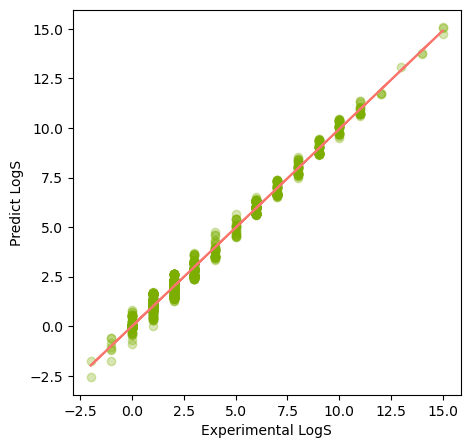

In [289]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5,5))
plt.scatter(x=y_gks, y=y_lr_train_pred_gks, c="#7CAE00" ,alpha=0.3)

z = np.polyfit(y_gks, y_lr_train_pred_gks, 1)
p = np.poly1d(z)

plt.plot(y_gks, p(y_gks), '#F8766D')
plt.ylabel('Predict LogS')
plt.xlabel('Experimental LogS')

## Fwds

In [ ]:
reg_fwds = LinearRegression().fit(x_gks, y_gks)

In [23]:
from sklearn.linear_model import SGDRegressor

In [29]:
model = SGDRegressor(max_iter=2000, tol=None)

In [31]:
model.partial_fit(X_train_gks, y_train_gks)

SGDRegressor(max_iter=2000, tol=None)

In [33]:
# URL of the CSV file (example)
url = "https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2022-23/gws/merged_gw.csv"

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(url)

gks=df.loc[df['position']=="GK"]
defs=df.loc[df['position']=="DEF"]
mids=df.loc[df['position']=="MID"]
fwds=df.loc[df['position']=="FWD"]

y_gks=gks['total_points']
y_defs=defs['total_points']
y_mids=mids['total_points']
y_fwds=fwds['total_points']

x_gks=gks.drop(['total_points', 'name', 'position', 'team', 'starts', 'kickoff_time'], axis =1)
x_defs=defs.drop(['total_points', 'name', 'position', 'team', 'starts', 'kickoff_time'], axis =1)
x_mids=mids.drop(['total_points', 'name', 'position', 'team', 'starts', 'kickoff_time'], axis =1)
x_fwds=fwds.drop(['total_points', 'name', 'position', 'team', 'starts', 'kickoff_time'], axis =1)

X_train_gks, X_test_gks, y_train_gks, y_test_gks = train_test_split(
  x_gks, y_gks, random_state=104,test_size=0.2, shuffle=False)

In [34]:
model.partial_fit(X_train_gks, y_train_gks)

SGDRegressor(max_iter=2000, tol=None)

In [53]:
X_train_gks

,xP,assists,bonus,bps,clean_sheets,creativity,element,expected_assists,expected_goal_involvements,expected_goals,...,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
10,1.5,0,0,0,0,0.0,451,0.0,0.0,0.0,...,1,4,0.0,0,0,0,40,True,0,1
14,5.5,0,0,11,0,0.0,281,0.0,0.0,0.0,...,2,2,0.0,0,0,0,55,False,0,1
20,0.5,0,0,0,0,0.0,102,0.0,0.0,0.0,...,2,1,0.0,0,0,0,40,False,0,1
24,0.7,0,0,11,0,0.0,213,0.0,0.0,0.0,...,2,2,0.0,0,0,0,45,True,0,1
27,1.5,0,0,0,0,0.0,353,0.0,0.0,0.0,...,0,2,0.0,0,0,0,40,True,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21344,0.0,0,0,0,0,0.0,717,0.0,0.0,0.0,...,1,2,0.0,101,165,64,40,False,0,32
21347,0.0,0,0,0,0,0.0,644,0.0,0.0,0.0,...,0,0,0.0,5,97,92,40,True,0,32
21348,0.0,0,0,0,0,0.0,627,0.0,0.0,0.0,...,0,0,0.0,-10,0,10,40,False,0,32
21352,0.5,0,0,0,0,0.0,289,0.0,0.0,0.0,...,2,3,0.0,-136,191,327,40,True,0,32


In [37]:
y_pred = model.predict(X_test_gks)

In [49]:
y_pred

array([-1.21816645e+19, -1.08096990e+19, -2.24312309e+17, -5.17209638e+19,
       -3.76967980e+17, -9.45825972e+19, -2.44558553e+20, -1.57209775e+21,
       -2.06703272e+19, -6.07117484e+17, -1.14416633e+21, -2.37682905e+20,
       -1.18639806e+19, -5.52055589e+19, -2.94212531e+20, -1.05821561e+19,
       -7.08847006e+19, -1.18513959e+18, -2.89040100e+19, -5.54673071e+17,
       -1.19204416e+18, -3.96048572e+20, -2.63979064e+19, -2.99040125e+18,
       -3.21980748e+19, -7.84525575e+20, -4.33612358e+20, -1.17479570e+21,
       -1.35472687e+21, -3.00639113e+18, -1.20081089e+21, -1.09644824e+20,
       -8.80878342e+17, -9.43702095e+18, -5.10338068e+19, -4.12419352e+18,
       -8.80896275e+18, -3.17487387e+17, -1.20044279e+18, -8.44993090e+16,
       -7.27792291e+20, -2.02222248e+18, -2.03177515e+18, -5.18702249e+19,
       -1.10428313e+20, -2.83028480e+20, -4.98351213e+20, -9.26143390e+17,
       -1.02033094e+20, -3.65655176e+18, -8.17985418e+17, -9.14158062e+19,
       -1.70882158e+18, -

In [43]:

from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test_gks, y_pred)
r2 = r2_score(y_test_gks, y_pred)



In [45]:
mse

1.7030125561088398e+41

In [47]:
r2

-4.391584760684341e+40